## Concrete Crack Image Detection

Given *images of concrete surfaces*, let's try to detect **cracks** in the concrete.

We will use a TensorFlow CNN to make our predictions. 

Data Source: https://www.kaggle.com/datasets/arunrk7/surface-crack-detection

### Getting Started

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
positive_dir = Path('archive/Positive')
negative_dir = Path('archive/Negative')

### Creating DataFrames

In [3]:
list(positive_dir.glob(r'*.jpg'))

[PosixPath('archive/Positive/19079_1.jpg'),
 PosixPath('archive/Positive/04212.jpg'),
 PosixPath('archive/Positive/05083.jpg'),
 PosixPath('archive/Positive/07891.jpg'),
 PosixPath('archive/Positive/16983_1.jpg'),
 PosixPath('archive/Positive/00309.jpg'),
 PosixPath('archive/Positive/01895.jpg'),
 PosixPath('archive/Positive/04529.jpg'),
 PosixPath('archive/Positive/09478.jpg'),
 PosixPath('archive/Positive/11133_1.jpg'),
 PosixPath('archive/Positive/17005_1.jpg'),
 PosixPath('archive/Positive/00162.jpg'),
 PosixPath('archive/Positive/01576.jpg'),
 PosixPath('archive/Positive/19648.jpg'),
 PosixPath('archive/Positive/12056_1.jpg'),
 PosixPath('archive/Positive/10696_1.jpg'),
 PosixPath('archive/Positive/04727.jpg'),
 PosixPath('archive/Positive/15657_1.jpg'),
 PosixPath('archive/Positive/03457.jpg'),
 PosixPath('archive/Positive/09253.jpg'),
 PosixPath('archive/Positive/01627.jpg'),
 PosixPath('archive/Positive/14286_1.jpg'),
 PosixPath('archive/Positive/03081.jpg'),
 PosixPath('archiv

In [4]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [5]:
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")

all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df

,Filepath,Label
0,archive/Positive/17583_1.jpg,POSITIVE
1,archive/Positive/01928.jpg,POSITIVE
2,archive/Positive/15494_1.jpg,POSITIVE
3,archive/Negative/10736.jpg,NEGATIVE
4,archive/Positive/11852_1.jpg,POSITIVE
...,...,...
39995,archive/Positive/02430.jpg,POSITIVE
39996,archive/Negative/15109.jpg,NEGATIVE
39997,archive/Positive/19223_1.jpg,POSITIVE
39998,archive/Positive/00077.jpg,POSITIVE


In [6]:
train_df, test_df = train_test_split(
    all_df.sample(6000, random_state=1),
    train_size=0.7,
    shuffle=True,
    random_state=1
)

In [7]:
train_df

,Filepath,Label
30189,archive/Negative/02375.jpg,NEGATIVE
8931,archive/Negative/01794.jpg,NEGATIVE
29084,archive/Positive/11736_1.jpg,POSITIVE
29189,archive/Negative/16787.jpg,NEGATIVE
2645,archive/Negative/18230.jpg,NEGATIVE
...,...,...
2090,archive/Positive/09882.jpg,POSITIVE
35101,archive/Positive/11271_1.jpg,POSITIVE
8720,archive/Positive/02646.jpg,POSITIVE
9955,archive/Positive/15568_1.jpg,POSITIVE


In [8]:
test_df

,Filepath,Label
15731,archive/Negative/02727.jpg,NEGATIVE
34272,archive/Negative/01017.jpg,NEGATIVE
39532,archive/Positive/13750_1.jpg,POSITIVE
10818,archive/Positive/19934.jpg,POSITIVE
35421,archive/Negative/02485.jpg,NEGATIVE
...,...,...
7174,archive/Positive/01000.jpg,POSITIVE
27207,archive/Negative/09879.jpg,NEGATIVE
28566,archive/Negative/12874.jpg,NEGATIVE
20688,archive/Positive/12048_1.jpg,POSITIVE


### Loading Image Data

In [9]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [10]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = test_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 3360 validated image filenames belonging to 2 classes.
Found 840 validated image filenames belonging to 2 classes.
Found 1800 validated image filenames belonging to 2 classes.


### Training

In [11]:
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             


2024-11-20 16:31:31.906395: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
history = model.fit(
    train_data,
    validation_data = val_data,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100


2024-11-20 16:31:32.342979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


105/105 [==============================] - ETA: 0s - loss: 0.6825 - accuracy: 0.5955

2024-11-20 16:31:56.506528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


105/105 [==============================] - 29s 269ms/step - loss: 0.6825 - accuracy: 0.5955 - val_loss: 0.6645 - val_accuracy: 0.7036
Epoch 2/100
105/105 [==============================] - 23s 219ms/step - loss: 0.6318 - accuracy: 0.6896 - val_loss: 0.6039 - val_accuracy: 0.6857
Epoch 3/100
105/105 [==============================] - 22s 212ms/step - loss: 0.5633 - accuracy: 0.7500 - val_loss: 0.5181 - val_accuracy: 0.8381
Epoch 4/100
105/105 [==============================] - 26s 244ms/step - loss: 0.4753 - accuracy: 0.8491 - val_loss: 0.4475 - val_accuracy: 0.8964
Epoch 5/100
105/105 [==============================] - 22s 207ms/step - loss: 0.3940 - accuracy: 0.9018 - val_loss: 0.3962 - val_accuracy: 0.9060
Epoch 6/100
105/105 [==============================] - 21s 196ms/step - loss: 0.3176 - accuracy: 0.9211 - val_loss: 0.3159 - val_accuracy: 0.9298
Epoch 7/100
105/105 [==============================] - 20s 191ms/step - loss: 0.2632 - accuracy: 0.9312 - val_loss: 0.3089 - val_accurac

In [19]:
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title = "Training and Validation Loss Over Time"
)
fig.show(renderer='browser')

### Results

In [20]:
model.predict(test_data)

 1/57 [..............................] - ETA: 10s

2024-11-20 17:03:37.917372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 4s 76ms/step


array([[0.02567573],
       [0.0138261 ],
       [0.9999998 ],
       ...,
       [0.01366935],
       [0.9999982 ],
       [1.        ]], dtype=float32)

In [21]:
test_data.labels

[0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,


In [22]:
def evaluate_model(model, test_data):
    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]
    print("   Test Loss : {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc*100))

    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))
    cm = confusion_matrix(test_data.labels, y_pred)
    clr = classification_report(test_data.labels, y_pred, target_names=['NEGATIVE', 'POSITIVE'])

    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=['NEGATIVE', 'POSITIVE'])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=['NEGATIVE', 'POSITIVE'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    print("Clasification Report: \n------------------\n", clr)

2024-11-20 17:12:00.440477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Test Loss : 0.06112
Test Accuracy: 97.61%
 1/57 [..............................] - ETA: 10s

2024-11-20 17:12:10.781312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 6s 100ms/step


/tmp/ipykernel_45368/1267553377.py:8: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



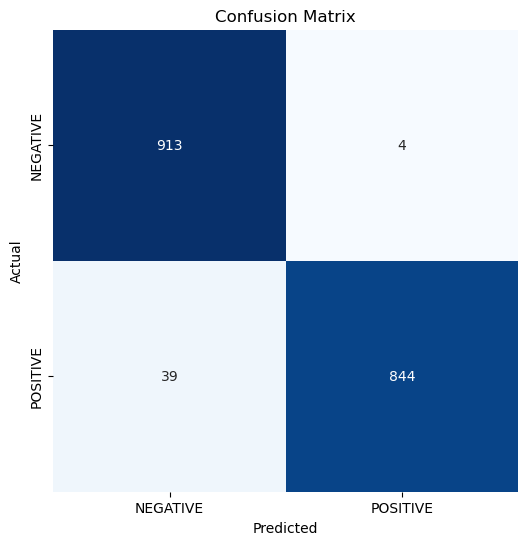

Clasification Report: 
------------------
               precision    recall  f1-score   support

    NEGATIVE       0.96      1.00      0.98       917
    POSITIVE       1.00      0.96      0.98       883

    accuracy                           0.98      1800
   macro avg       0.98      0.98      0.98      1800
weighted avg       0.98      0.98      0.98      1800



In [23]:
evaluate_model(model, test_data)